## GTZAN Expansion
A larger dataset can enhance the performance of a transformer model during fine-tuning. In this notebook, I double the dataset size by spliting audios (randomly) into two parts.

In [ ]:
## Needed Libraries


# For Data
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt



#Audio
import librosa
import librosa.display

from IPython.display import Audio



#from IPython.display import Audio

!pip install datasets
from datasets import load_dataset, Audio


# transformers
!pip install git+https://github.com/huggingface/transformers
!pip install -U transformers
!pip install evaluate

#the `Trainer` with `PyTorch` requires `accelerate>=0.21.0`. So we need one the below lines
!pip install -U accelerate
#pip install transformers[torch]



In [ ]:
#To get the notebook connected to google drive
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


## Loading the GTZAN

In [ ]:
# loading data

gtzan = load_dataset("marsyas/gtzan", "all")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1486: FutureWarning: The repository for marsyas/gtzan contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/marsyas/gtzan
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.war

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
gtzan

DatasetDict({
    train: Dataset({
        features: ['file', 'audio', 'genre'],
        num_rows: 999
    })
})

In [ ]:
# Resampling Audio to 16000 Hz

from datasets import Audio
gtzan = gtzan.cast_column("audio", Audio(sampling_rate=16000))

In [ ]:
# making a copy of gtzan
songs = gtzan.copy()

In [ ]:
songs["train"][0]


{'file': '/root/.cache/huggingface/datasets/downloads/extracted/5022b0984afa7334ff9a3c60566280b08b5179d4ac96a628052bada7d8940244/genres/blues/blues.00000.wav',
 'audio': {'path': '/root/.cache/huggingface/datasets/downloads/extracted/5022b0984afa7334ff9a3c60566280b08b5179d4ac96a628052bada7d8940244/genres/blues/blues.00000.wav',
  'array': array([ 0.00766408,  0.01497506, -0.00178931, ..., -0.05508532,
         -0.06770003,  0.        ]),
  'sampling_rate': 16000},
 'genre': 0}

The `file` contains. The `audio` column also has the audio signal (represented as a 1-dimensional NumPy array), and sampling rate (44100 in this case). We can also see the `genre` is represented as an integer, or class label, which is the format the model will make it’s predictions in. We can use the int2str() method of the genre feature to map these integers to actual genre

In [ ]:
# first song genre
sample = songs["train"][0]
sample["genre"]

0

In [ ]:
#int2str() method
id2label_fn = songs["train"].features["genre"].int2str
id2label_fn(songs["train"][0]["genre"])

'blues'

## Dataset Expansion


This function splits an audio into two parts, taking the audio array, the number of splits, and a local directory address to save the splits.

In [ ]:
import random
import math
import os
import soundfile as sf

def split_and_save_audio(sample, output_dir, num_parts, sub_length=10, min_gap=3):
    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Extract audio array and sampling rate from the sample
    audio_array = sample["audio"]["array"]
    sampling_rate = sample["audio"]["sampling_rate"]

    # Compute the maximum start index for a sub audio to fit
    max_start_index = len(audio_array) - math.ceil(sub_length * sampling_rate)

    # Select the first start index
    first_start_index = random.randint(0, max_start_index)

    # Calculate the range for the second start index to maintain at least min_gap seconds distance
    min_second_start = first_start_index + math.ceil((sub_length + min_gap) * sampling_rate)
    max_second_start = max_start_index
    if min_second_start > max_second_start:
        # If the range is invalid due to min_gap, adjust the first start index or reduce min_gap
        # For simplicity, let's adjust the first start index backwards
        first_start_index = random.randint(0, max_start_index - math.ceil((sub_length + min_gap) * sampling_rate))
        min_second_start = first_start_index + math.ceil((sub_length + min_gap) * sampling_rate)

    second_start_index = random.randint(min_second_start, max_second_start)

    # List of start indices
    start_indices = [first_start_index, second_start_index]

    new_files = []
    new_audios = []
    new_genres = []

    for idx, start_index in enumerate(start_indices):
        # Extract the sub-audio based on the start index and sub_audio_length
        sub_audio = audio_array[start_index:start_index + math.ceil(sub_length * sampling_rate)]

        # Construct a new file name and path for each sub part
        base_name = os.path.basename(sample["file"])
        new_file_name = f"{os.path.splitext(base_name)[0]}_part{idx + 1}{os.path.splitext(base_name)[1]}"
        new_file_path = os.path.join(output_dir, new_file_name)

        # Save the audio part to a new file
        sf.write(new_file_path, sub_audio, sampling_rate)

        # Create an audio and a genre feature for the sub part
        new_audio = {
            'path': new_file_path,
            'array': sub_audio,
            'sampling_rate': sampling_rate
        }
        new_genre = sample['genre']

        # Append the new audio, file, and the genre to the lists
        new_audios.append(new_audio)
        new_files.append(new_file_path)
        new_genres.append(new_genre)

    # Return both the new file paths and the audio arrays
    return new_files, new_audios, new_genres


In [ ]:
### Apply the Splitting Function to an example from the Dataset
output_dir = '/content/drive/MyDrive/Colab Notebooks/Sample'


new_files, new_audios, new_genres = split_and_save_audio(sample,output_dir, 2)
new_audios

[{'path': '/content/drive/MyDrive/Colab Notebooks/Sample/blues.00000_part1.wav',
  'array': array([-0.02000699, -0.01382252, -0.00882979, ...,  0.28396043,
          0.2293779 ,  0.15213442]),
  'sampling_rate': 16000},
 {'path': '/content/drive/MyDrive/Colab Notebooks/Sample/blues.00000_part2.wav',
  'array': array([-0.10412975, -0.07357007, -0.11874785, ..., -0.05508532,
         -0.06770003,  0.        ]),
  'sampling_rate': 16000}]

In [ ]:
### Sanity check
from IPython.display import Audio

# Replace the paths with the paths to your audio files
audio_path_1 = new_audios[0]['path']
audio_path_2 = new_audios[1]['path']


In [ ]:
# Play the first audio
print("Playing the first audio:")
Audio(audio_path_1)

Playing the first audio:


In [ ]:
# Play the second audio
print("Playing the second audio:")
Audio(audio_path_2)

Playing the second audio:


In [ ]:
expanded_songs = []
output_dir = '/content/drive/MyDrive/Colab Notebooks/splited-gtzan'

for example in songs['train']:

    new_files, new_audios, new_genres = split_and_save_audio(example, output_dir, 2)

    for files, audio, genre in zip(new_files, new_audios, new_genres):
        # Append new entry to the expanded dataset
        expanded_songs.append({
            'file': files,
            'audio': audio,
            'genre': genre
        })


### Convert the Expanded List into a Dataset

In [ ]:
from datasets import Dataset

# Extract featurea
original_features = songs["train"].features

# Convert list of dictionaries to dictionary of lists
dataset_dict = {feature: [] for feature in original_features}
for feature in dataset_dict.keys():
    dataset_dict[feature] = [d[feature] for d in expanded_songs]

# Now use the from_dict method correctly
expanded_dataset = Dataset.from_dict(dataset_dict, features=original_features)

# savev the dataset (optional)
dir = "/content/drive/MyDrive/Colab Notebooks/Splited_GTZAN"
expanded_dataset.save_to_disk(dir)

Saving the dataset (0/2 shards):   0%|          | 0/1998 [00:00<?, ? examples/s]

In [ ]:
expanded_dataset

Dataset({
    features: ['file', 'audio', 'genre'],
    num_rows: 1998
})

The dataset contains 1998 data each comes with three columns: `file`, `audio`, and `genre`.

The `file` contains the path. The `audio` column also has the audio signal (represented as a 1-dimensional NumPy array), and sampling rate (16000 in this case). We can also see the `genre` is represented as an integer, or class label, which is the format the model will make it’s predictions in.

In [ ]:
from collections import Counter

genre_counts = Counter(expanded_dataset['genre'])
print(genre_counts)



Counter({0: 200, 1: 200, 2: 200, 3: 200, 4: 200, 6: 200, 7: 200, 8: 200, 9: 200, 5: 198})


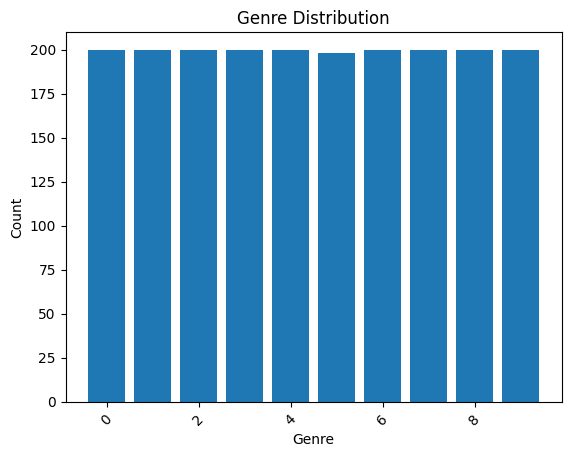

In [ ]:
# plot the labels
import seaborn as sns


# Extracting genre labels and counts
genres = list(genre_counts.keys())
counts = list(genre_counts.values())

# Plotting
plt.bar(genres, counts)
plt.xlabel('Genre')
plt.ylabel('Count')
plt.title('Genre Distribution')
plt.xticks(rotation=45)  # Rotate x labels for better readability
plt.show()
